In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from ast import literal_eval

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import IPython.display as ipd

import requests
import os
from varname import argname
from pydub import AudioSegment
import librosa
import librosa.display

import pickle

In [2]:
mp3s = pd.read_csv('data/collection_1_mp3s.csv', index_col=0)

In [3]:
mp3s['artists'] = mp3s['artists'].map(lambda x: literal_eval(x))

In [6]:
mp3s[mp3s['track'] == "3 Headed Goat (feat. Lil Baby & Polo G)"]

,id,popularity,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url
1428,14c8arYQPMtxPcF4L4FYXC,46,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",Just Cause Y'all Waited 2 (Deluxe),album,2020-06-26,https://i.scdn.co/image/ab67616d0000b273fec5f2...,169531,https://p.scdn.co/mp3-preview/c9e5678e476335fb...
4297,5BSUxDJ8HcOWZD2KfExs7b,40,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",Just Cause Y'all Waited 2,album,2020-05-08,https://i.scdn.co/image/ab67616d0000b27390715e...,169531,https://p.scdn.co/mp3-preview/0270658a09c7cb98...
6133,6Tguhaf2uAe6OjRLsR2Tql,76,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",Just Cause Y'all Waited 2,album,2020-05-08,https://i.scdn.co/image/ab67616d0000b273f8558e...,169531,https://p.scdn.co/mp3-preview/6fca5999192d1a63...
14980,7J7UEZ08wc5aDsHgYpf8zI,6,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",Just Cause Y'all Waited 2 (Deluxe),album,2020-06-26,https://i.scdn.co/image/ab67616d0000b273bdce61...,169531,https://p.scdn.co/mp3-preview/fc4d8f65308509e2...
20285,4YEQWYhkJHgsm3Plul2FO2,28,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",3 Headed Goat (feat. Lil Baby & Polo G),single,2020-05-07,https://i.scdn.co/image/ab67616d0000b273f9e7c1...,169531,https://p.scdn.co/mp3-preview/668a0f3e8babff9a...
21203,77C9MDQMGrzKlgsUwWzr6I,28,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",3 Headed Goat (feat. Lil Baby & Polo G),single,2020-05-07,https://i.scdn.co/image/ab67616d0000b27368df4d...,169531,https://p.scdn.co/mp3-preview/4c0c14e0309ed608...


In [7]:
# there are duplicate songs from different albums (single, album, etc.)
# if they have different popularity scores, that's still valuable info, however
mp3s[mp3s.duplicated(subset=['track','duration_ms','popularity'], 
                     keep=False)]['track'].value_counts()

6 'N the Mornin'                           6
9ja Hip Hop                                3
One Punch Wulf                             2
50/50 Love                                 2
Zero Survivors                             2
60%                                        2
Studio 54                                  2
Face Off                                   2
96 Freestyle                               2
6565                                       2
80's - Instrumental - Remastered           2
Aries (feat. Peter Hook and Georgia)       2
SAME THING                                 2
Sex Cells                                  2
Seven Day Hustle                           2
6itch remix - feat. Nitro                  2
8 Figures                                  2
Ring (feat. Young Thug)                    2
Jazz Hands                                 2
3 Headed Goat (feat. Lil Baby & Polo G)    2
Just Mellow - Norman Cook 7'' Remix        2
8 Missed Calls                             2
Name: trac

In [8]:
mp3s.shape

(16194, 10)

In [9]:
mp3s.drop_duplicates(subset=['track','duration_ms','popularity'], inplace=True)
mp3s.shape

(16168, 10)

In [10]:
# making train test holdout splits

X = mp3s.drop(columns=['popularity'])
y = mp3s['popularity']

X_pretr, X_holdout, y_pretr, y_holdout = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_pretr, y_pretr, 
                                                    test_size=15/90, random_state=42)
print(X_train.shape, X_test.shape, X_holdout.shape)

(12125, 9) (2426, 9) (1617, 9)


<AxesSubplot:>

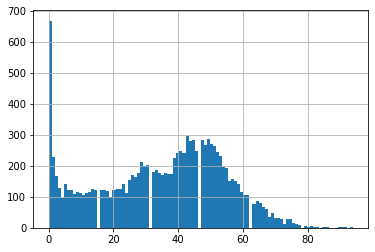

In [11]:
# 39 seems to be a good cutoff
y_train.hist(bins=100)

In [12]:
# defining popular as >= 39 and encoding (1 = popular)
y_train = y_train.map(lambda x: 1 if x >= 39 else 0)
y_train.value_counts(normalize=True)

0    0.512
1    0.488
Name: popularity, dtype: float64

In [13]:
y_test = y_test.map(lambda x: 1 if x >= 39 else 0)
y_test.value_counts(normalize=True)

0    0.516076
1    0.483924
Name: popularity, dtype: float64

In [14]:
y_holdout = y_holdout.map(lambda x: 1 if x >= 39 else 0)
y_holdout.value_counts(normalize=True)

0    0.506494
1    0.493506
Name: popularity, dtype: float64

In [15]:
def get_mp3(http, directory, name):
    try:
        r = requests.get(http, timeout=2)
        with open(f'{directory}/{name}.mp3', 'wb') as f:
            f.write(r.content)
        print(f'mp3 acquision: {name}.mp3')
    except:
        print(f'mp3 timeout: index {name}')

In [16]:
class LibrosaProcessing:
    def __init__(self, split, data, target):
        self.data_ = data.copy()
        self.target_ = target.copy()
        wd = !pwd
        self.directory_ = f'{wd[0]}/data/{split}'
        if not os.path.exists(self.directory_):
            os.mkdir(self.directory_)
        self.mp3_directory_ = f'{self.directory_}/mp3'
        self.wav_directory_ = f'{self.directory_}/wav'

    def get_mp3(self):
        if not os.path.exists(self.mp3_directory_):
            os.mkdir(self.mp3_directory_)
        self.data_['preview_url'].reset_index().apply(lambda x: get_mp3(x[1],
                                                                         self.mp3_directory_,
                                                                         x[0]), axis=1)
        print('mp3s acquired')
        
    def get_wav(self):
        if not os.path.exists(self.wav_directory_):
            os.mkdir(self.wav_directory_)
        for file in os.listdir(self.mp3_directory_):
            src = f'{self.mp3_directory_}/{file}'
            dest = f'{self.wav_directory_}/{file.split(".")[0]}.wav'
            AudioSegment.from_mp3(src).export(dest, format='wav')
            self.data_.loc[int(file.split(".")[0]),
                            'file_path'] = dest
        for index in self.data_.index:
            if pd.isnull(self.data_['file_path'].loc[index]):
                self.target_.drop(index, inplace=True)
                self.data_.drop(index, inplace=True)
                print(f'NaN wav: index {index}')
        self.wav_ = self.data_['file_path'].copy()
    
    def get_wav_path(self):
        for file in os.listdir(self.wav_directory_):
            self.data_.loc[int(file.split(".")[0]),
                            'file_path'] = f'{self.wav_directory_}/{file}'
        for index in self.data_.index:
            if pd.isnull(self.data_['file_path'].loc[index]):
                self.target_.drop(index, inplace=True)
                self.data_.drop(index, inplace=True)
                print(f'NaN wav: index {index}')
        self.wav_ = self.data_['file_path'].copy()

    def get_mel_spec(self):
        self.specs_pre_ = []
        self.spaxmax1_ = 128 # max size in dimension 1 for X_train
        self.spaxmax2_ = 1292 # max size in dimension 2 for X_train
        for count, song in enumerate(self.wav_, start=1):
            y, sr = librosa.load(song, duration=30)
            spec = librosa.power_to_db(librosa.feature.melspectrogram(y=y,sr=sr), ref=np.min)
            self.specs_pre_.append(spec[np.newaxis, ..., np.newaxis])
            print(f"wavs run: {count}/{len(self.wav_)}")
        resized = []
        for spec in self.specs_pre_:
            resized.append(np.resize(spec, (1, self.spaxmax1_, self.spaxmax2_, 1)))
        self.mel_specs_ = np.concatenate(resized, axis=0)
        return (self.mel_specs_, self.target_)
    
    def get_mfcc(self):
        pass
#         librosa.        
#         return 

In [17]:
raw_datadict = {'X_train': (X_train, y_train), 
            'X_test': (X_test, y_test),
            'X_holdout': (X_holdout, y_holdout)}

In [18]:
with open('mel_spec_dict.pkl', 'rb') as up:
    mel_spec_datadict = pickle.load(up)

In [31]:
mel_spec_datadict.keys()

dict_keys(['X_train', 'X_test', 'X_holdout'])

In [32]:
mel_spec_datadict['X_holdout'][0].shape

(1615, 128, 1292, 1)

In [30]:
for split, info in raw_datadict.items():
    if split == 'X_train':
        continue
#         lp = LibrosaProcessing(split, info[0], info[1])
#         lp.get_mp3()
#         lp.get_wav()
#         mel_spec_datadict[split] = lp.get_mel_spec()
    if split == 'X_test':
        continue
#         lp2 = LibrosaProcessing(split, info[0], info[1])
#         lp2.get_mp3()
#         lp2.get_wav()
#         mel_spec_datadict[split] = lp2.get_mel_spec()
    if split == 'X_holdout':
        continue
#         lp3 = LibrosaProcessing(split, info[0], info[1])
#         lp3.get_mp3()
#         lp3.get_wav()
#         mel_spec_datadict[split] = lp3.get_mel_spec()

mp3 acquision: 1385.mp3
mp3 acquision: 10469.mp3
mp3 acquision: 9740.mp3
mp3 acquision: 350.mp3
mp3 acquision: 21206.mp3
mp3 acquision: 556.mp3
mp3 acquision: 14554.mp3
mp3 acquision: 5161.mp3
mp3 acquision: 12530.mp3
mp3 acquision: 6688.mp3
mp3 acquision: 8762.mp3
mp3 acquision: 10961.mp3
mp3 acquision: 20455.mp3
mp3 acquision: 12748.mp3
mp3 acquision: 11218.mp3
mp3 acquision: 21422.mp3
mp3 acquision: 5204.mp3
mp3 acquision: 3401.mp3
mp3 acquision: 21309.mp3
mp3 acquision: 6891.mp3
mp3 acquision: 933.mp3
mp3 acquision: 15721.mp3
mp3 acquision: 8794.mp3
mp3 acquision: 5136.mp3
mp3 acquision: 1453.mp3
mp3 acquision: 19207.mp3
mp3 acquision: 1773.mp3
mp3 acquision: 14165.mp3
mp3 acquision: 3063.mp3
mp3 acquision: 18950.mp3
mp3 acquision: 20408.mp3
mp3 acquision: 4303.mp3
mp3 acquision: 4957.mp3
mp3 acquision: 1785.mp3
mp3 acquision: 4772.mp3
mp3 acquision: 16081.mp3
mp3 acquision: 16242.mp3
mp3 acquision: 3265.mp3
mp3 acquision: 6704.mp3
mp3 acquision: 17841.mp3
mp3 acquision: 1103.mp3
m

mp3 acquision: 13586.mp3
mp3 acquision: 11745.mp3
mp3 acquision: 11737.mp3
mp3 acquision: 12254.mp3
mp3 acquision: 12448.mp3
mp3 acquision: 16731.mp3
mp3 acquision: 14538.mp3
mp3 acquision: 4165.mp3
mp3 acquision: 4577.mp3
mp3 acquision: 20087.mp3
mp3 acquision: 12968.mp3
mp3 acquision: 4818.mp3
mp3 acquision: 5479.mp3
mp3 acquision: 6635.mp3
mp3 acquision: 9338.mp3
mp3 acquision: 1339.mp3
mp3 acquision: 19088.mp3
mp3 acquision: 8811.mp3
mp3 acquision: 20989.mp3
mp3 acquision: 19123.mp3
mp3 acquision: 11658.mp3
mp3 acquision: 17796.mp3
mp3 acquision: 15742.mp3
mp3 acquision: 231.mp3
mp3 acquision: 9895.mp3
mp3 acquision: 16902.mp3
mp3 acquision: 3071.mp3
mp3 acquision: 3049.mp3
mp3 acquision: 12302.mp3
mp3 acquision: 14964.mp3
mp3 acquision: 10119.mp3
mp3 acquision: 4510.mp3
mp3 acquision: 2561.mp3
mp3 acquision: 7597.mp3
mp3 acquision: 13166.mp3
mp3 acquision: 3346.mp3
mp3 acquision: 13919.mp3
mp3 acquision: 11933.mp3
mp3 acquision: 11539.mp3
mp3 acquision: 20690.mp3
mp3 acquision: 15

mp3 acquision: 2966.mp3
mp3 acquision: 4115.mp3
mp3 acquision: 8442.mp3
mp3 acquision: 1716.mp3
mp3 acquision: 2943.mp3
mp3 acquision: 3092.mp3
mp3 acquision: 19871.mp3
mp3 acquision: 17544.mp3
mp3 acquision: 9615.mp3
mp3 acquision: 4847.mp3
mp3 acquision: 508.mp3
mp3 acquision: 20241.mp3
mp3 acquision: 14393.mp3
mp3 acquision: 10857.mp3
mp3 acquision: 20339.mp3
mp3 acquision: 2386.mp3
mp3 acquision: 6087.mp3
mp3 acquision: 10674.mp3
mp3 acquision: 3828.mp3
mp3 acquision: 15012.mp3
mp3 acquision: 12634.mp3
mp3 acquision: 16581.mp3
mp3 acquision: 18251.mp3
mp3 acquision: 16710.mp3
mp3 acquision: 5397.mp3
mp3 acquision: 207.mp3
mp3 acquision: 5251.mp3
mp3 acquision: 17353.mp3
mp3 acquision: 20201.mp3
mp3 acquision: 15346.mp3
mp3 acquision: 510.mp3
mp3 acquision: 4318.mp3
mp3 acquision: 19284.mp3
mp3 acquision: 15946.mp3
mp3 acquision: 2483.mp3
mp3 acquision: 2163.mp3
mp3 acquision: 13633.mp3
mp3 acquision: 17731.mp3
mp3 acquision: 834.mp3
mp3 acquision: 21209.mp3
mp3 acquision: 2230.mp3


mp3 acquision: 19126.mp3
mp3 acquision: 1137.mp3
mp3 acquision: 719.mp3
mp3 acquision: 14826.mp3
mp3 acquision: 6659.mp3
mp3 acquision: 1844.mp3
mp3 acquision: 6196.mp3
mp3 acquision: 2753.mp3
mp3 acquision: 5875.mp3
mp3 acquision: 10154.mp3
mp3 acquision: 1943.mp3
mp3 acquision: 17062.mp3
mp3 acquision: 13852.mp3
mp3 acquision: 15286.mp3
mp3 acquision: 1824.mp3
mp3 acquision: 17604.mp3
mp3 acquision: 18473.mp3
mp3 acquision: 19767.mp3
mp3 acquision: 7669.mp3
mp3 acquision: 18387.mp3
mp3 acquision: 18947.mp3
mp3 acquision: 2839.mp3
mp3 acquision: 7476.mp3
mp3 acquision: 12553.mp3
mp3 acquision: 9985.mp3
mp3 acquision: 18948.mp3
mp3 acquision: 2529.mp3
mp3 acquision: 21424.mp3
mp3 acquision: 6575.mp3
mp3 acquision: 21061.mp3
mp3 acquision: 11208.mp3
mp3 acquision: 10376.mp3
mp3 acquision: 1164.mp3
mp3 acquision: 21200.mp3
mp3 acquision: 15276.mp3
mp3 acquision: 10152.mp3
mp3 acquision: 536.mp3
mp3 acquision: 10288.mp3
mp3 acquision: 20103.mp3
mp3 acquision: 11777.mp3
mp3 acquision: 533.

mp3 acquision: 9931.mp3
mp3 acquision: 7302.mp3
mp3 acquision: 7428.mp3
mp3 acquision: 2055.mp3
mp3 acquision: 19075.mp3
mp3 acquision: 20514.mp3
mp3 acquision: 19452.mp3
mp3 acquision: 1739.mp3
mp3 acquision: 1952.mp3
mp3 acquision: 10571.mp3
mp3 acquision: 4287.mp3
mp3 acquision: 6851.mp3
mp3 acquision: 21377.mp3
mp3 acquision: 11221.mp3
mp3 acquision: 13966.mp3
mp3 acquision: 12785.mp3
mp3 acquision: 12945.mp3
mp3 acquision: 11307.mp3
mp3 acquision: 10887.mp3
mp3 acquision: 16262.mp3
mp3 acquision: 5144.mp3
mp3 acquision: 18997.mp3
mp3 acquision: 19309.mp3
mp3 acquision: 10381.mp3
mp3 acquision: 18986.mp3
mp3 acquision: 12324.mp3
mp3 acquision: 17231.mp3
mp3 acquision: 9806.mp3
mp3 acquision: 3951.mp3
mp3 acquision: 7848.mp3
mp3 acquision: 9110.mp3
mp3 acquision: 10524.mp3
mp3 acquision: 21096.mp3
mp3 acquision: 7792.mp3
mp3 acquision: 19481.mp3
mp3 acquision: 6436.mp3
mp3 acquision: 54.mp3
mp3 acquision: 4655.mp3
mp3 acquision: 17022.mp3
mp3 acquision: 15494.mp3
mp3 acquision: 453.

wavs run: 79/1615
wavs run: 80/1615
wavs run: 81/1615
wavs run: 82/1615
wavs run: 83/1615
wavs run: 84/1615
wavs run: 85/1615
wavs run: 86/1615
wavs run: 87/1615
wavs run: 88/1615
wavs run: 89/1615
wavs run: 90/1615
wavs run: 91/1615
wavs run: 92/1615
wavs run: 93/1615
wavs run: 94/1615
wavs run: 95/1615
wavs run: 96/1615
wavs run: 97/1615
wavs run: 98/1615
wavs run: 99/1615
wavs run: 100/1615
wavs run: 101/1615
wavs run: 102/1615
wavs run: 103/1615
wavs run: 104/1615
wavs run: 105/1615
wavs run: 106/1615
wavs run: 107/1615
wavs run: 108/1615
wavs run: 109/1615
wavs run: 110/1615
wavs run: 111/1615
wavs run: 112/1615
wavs run: 113/1615
wavs run: 114/1615
wavs run: 115/1615
wavs run: 116/1615
wavs run: 117/1615
wavs run: 118/1615
wavs run: 119/1615
wavs run: 120/1615
wavs run: 121/1615
wavs run: 122/1615
wavs run: 123/1615
wavs run: 124/1615
wavs run: 125/1615
wavs run: 126/1615
wavs run: 127/1615
wavs run: 128/1615
wavs run: 129/1615
wavs run: 130/1615
wavs run: 131/1615
wavs run: 132/

wavs run: 512/1615
wavs run: 513/1615
wavs run: 514/1615
wavs run: 515/1615
wavs run: 516/1615
wavs run: 517/1615
wavs run: 518/1615
wavs run: 519/1615
wavs run: 520/1615
wavs run: 521/1615
wavs run: 522/1615
wavs run: 523/1615
wavs run: 524/1615
wavs run: 525/1615
wavs run: 526/1615
wavs run: 527/1615
wavs run: 528/1615
wavs run: 529/1615
wavs run: 530/1615
wavs run: 531/1615
wavs run: 532/1615
wavs run: 533/1615
wavs run: 534/1615
wavs run: 535/1615
wavs run: 536/1615
wavs run: 537/1615
wavs run: 538/1615
wavs run: 539/1615
wavs run: 540/1615
wavs run: 541/1615
wavs run: 542/1615
wavs run: 543/1615
wavs run: 544/1615
wavs run: 545/1615
wavs run: 546/1615
wavs run: 547/1615
wavs run: 548/1615
wavs run: 549/1615
wavs run: 550/1615
wavs run: 551/1615
wavs run: 552/1615
wavs run: 553/1615
wavs run: 554/1615
wavs run: 555/1615
wavs run: 556/1615
wavs run: 557/1615
wavs run: 558/1615
wavs run: 559/1615
wavs run: 560/1615
wavs run: 561/1615
wavs run: 562/1615
wavs run: 563/1615
wavs run: 56

wavs run: 944/1615
wavs run: 945/1615
wavs run: 946/1615
wavs run: 947/1615
wavs run: 948/1615
wavs run: 949/1615
wavs run: 950/1615
wavs run: 951/1615
wavs run: 952/1615
wavs run: 953/1615
wavs run: 954/1615
wavs run: 955/1615
wavs run: 956/1615
wavs run: 957/1615
wavs run: 958/1615
wavs run: 959/1615
wavs run: 960/1615
wavs run: 961/1615
wavs run: 962/1615
wavs run: 963/1615
wavs run: 964/1615
wavs run: 965/1615
wavs run: 966/1615
wavs run: 967/1615
wavs run: 968/1615
wavs run: 969/1615
wavs run: 970/1615
wavs run: 971/1615
wavs run: 972/1615
wavs run: 973/1615
wavs run: 974/1615
wavs run: 975/1615
wavs run: 976/1615
wavs run: 977/1615
wavs run: 978/1615
wavs run: 979/1615
wavs run: 980/1615
wavs run: 981/1615
wavs run: 982/1615
wavs run: 983/1615
wavs run: 984/1615
wavs run: 985/1615
wavs run: 986/1615
wavs run: 987/1615
wavs run: 988/1615
wavs run: 989/1615
wavs run: 990/1615
wavs run: 991/1615
wavs run: 992/1615
wavs run: 993/1615
wavs run: 994/1615
wavs run: 995/1615
wavs run: 99

wavs run: 1357/1615
wavs run: 1358/1615
wavs run: 1359/1615
wavs run: 1360/1615
wavs run: 1361/1615
wavs run: 1362/1615
wavs run: 1363/1615
wavs run: 1364/1615
wavs run: 1365/1615
wavs run: 1366/1615
wavs run: 1367/1615
wavs run: 1368/1615
wavs run: 1369/1615
wavs run: 1370/1615
wavs run: 1371/1615
wavs run: 1372/1615
wavs run: 1373/1615
wavs run: 1374/1615
wavs run: 1375/1615
wavs run: 1376/1615
wavs run: 1377/1615
wavs run: 1378/1615
wavs run: 1379/1615
wavs run: 1380/1615
wavs run: 1381/1615
wavs run: 1382/1615
wavs run: 1383/1615
wavs run: 1384/1615
wavs run: 1385/1615
wavs run: 1386/1615
wavs run: 1387/1615
wavs run: 1388/1615
wavs run: 1389/1615
wavs run: 1390/1615
wavs run: 1391/1615
wavs run: 1392/1615
wavs run: 1393/1615
wavs run: 1394/1615
wavs run: 1395/1615
wavs run: 1396/1615
wavs run: 1397/1615
wavs run: 1398/1615
wavs run: 1399/1615
wavs run: 1400/1615
wavs run: 1401/1615
wavs run: 1402/1615
wavs run: 1403/1615
wavs run: 1404/1615
wavs run: 1405/1615
wavs run: 1406/1615


In [34]:
with open('mel_spec_dict.pkl', 'wb') as p:
    pickle.dump(mel_spec_datadict, p)

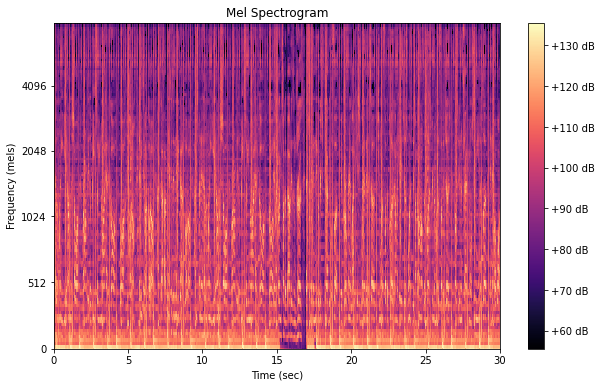

In [296]:
fig, ax = plt.subplots(figsize=(10,6))
img = librosa.display.specshow(lp.specs_pre_[2000][0,:,:,0], x_axis='time', 
                               y_axis='mel', fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel Spectrogram', xlabel='Time (sec)', ylabel='Frequency (mels)');

In [ ]:
y, sr = librosa.load(lp.wav_.iloc[0],duration=30)
ipd.Audio(y,rate=sr)

In [35]:
class MinMaxScaler:
    def fit(self, X_train):
        self.X_train_ = X_train
        self.max_ = self.X_train_.max()
        self.min_ = self.X_train_.min()
        
    def transform(self, X):
        return (X - self.min_) / (self.max_ - self.min_)
        

In [47]:
# Scaling
mm = MinMaxScaler()
mm.fit(mel_spec_datadict['X_train'][0])

mel_spec_sc = {}
for split, info in mel_spec_datadict.items():
    scaledX = mm.transform(info[0])
    mel_specs_sc[split] = (scaledX, info[1])


In [48]:
mel_specs_sc['X_test'][1].shape

(2426,)

In [49]:
with open('mel_spec_sc.pkl', 'wb') as p:
    pickle.dump(mel_spec_sc, p)